# Implicit Neural Representations for Image Compression
# Antoine Bohin - OVO Course - 28/02/2025

This notebook contains the code to reproduce and validate the results of the paper "Implicit Neural Representations for Image Compression" on two different datasets: CelebA and DIV2K.

Compressing images with INRs requires to train MLPs with a very high number of epochs in order to adequatly overfit the image. Meta-learning (one of the main contribution of the paper) also requires to train on a lots of samples from the corresponding dataset. Hence, training time for compression requires GPUs and is very long (took +20h to generate all the models required for the analysis) and **I would recommend to download the already overfitted MLPs and only run the last cells (Part 4.) to visualize the results. It doesn't require any GPU.**

In order to download the models, you can go on the associated github repository: https://github.com/AntoineBohin/ovo-inr-compression. They are all in the `exp/` folder. You also need to download the test images in the `data/test_celeba` and `data/test_DIV2K` folders.

# 0. Imports and utils

We begin by importing necessary libraries and utility functions. These include standard libraries for data handling and visualization, as well as custom modules for model definitions and training experiments.

In [1]:
import os
import json
import torch
import numpy as np
from types import SimpleNamespace
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Import necessary functions and classes
from models import INRNet
from scripts import basic_overfitting_experiment, maml_training, maml_overfitting_experiment
from training_utils import get_base_overfitting_experiment_folder, get_maml_overfitting_experiment_folder, compute_metrics

/Users/antoinebohin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/antoinebohin/Dropbox/Antoine/3A CS/SM10/OVO/ovo-inr-compression/training_utils.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Here, we define a configuration object that holds various settings for model architecture and training parameters. This includes settings for activation functions, encoding types, and learning rates.

In [2]:
CONFIG = SimpleNamespace(**{
    # General Settings
    "activation": "sine",
    "encoding": "nerf",
    "encoding_scale": 1.4,
    "ff_dims": 12, 
    "hidden_layers": 3,
    "hidden_dims": 32, 
    "data_root": "data",
    "exp_root": "exp/val_basic_celeba",
    "exp_glob": "*",
    "dataset": "test/celeba",
    "downscaling_factor": 1,

    # MAML Settings
    "inner_lr": 1e-5,
    "outer_lr": 5e-5,
    "lr_type": "per_parameter_per_step",
    "maml_adaptation_steps": 3,
    "maml_batch_size": 1,
    "maml_epochs": 1, #1
    "maml_dataset": "CelebA",
    "max_len": 10000,

    # Training Settings
    "batch_size": 1,
    "epochs": 10000,
    "epochs_til_ckpt": 5000,
    "steps_til_summary": 1000,
    "warmup": 100,
    "lr": 0.0005,
    "l1_reg": 1e-5,
    "patience": 500,
    "retrain_epochs": 300,
    "retrain_lr": 1e-6,
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# 1. Load Data (Don't execute if you don't want to train the models)

## Download Datasets

We download and prepare datasets required for training and validation. This includes the DIV2K and CelebA datasets, which are used for high-quality image compression experiments.

### DIV2K dataset (4 Go)

In [ ]:
os.makedirs("data/DIV2K", exist_ok=True)
!cd data/DIV2K
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip \*.zip
!rm *.zip
!cd ..
!cd ..

### CelebA Dataset


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Then make sure to move the downloaded files to the data/CelebA folder. Within the CelebA folder, you should have at least the following:
- A folder named `img_align_celeba/img_align_celeba` containing the images
- A file named `list_eval_partition.csv` containing the partition of the dataset (train/valid/test)

## Choose validation samples

### DIV2K validation samples
We chose two different images of high quality that show a lot of contrast and details.

In [ ]:
!mkdir -p data/test_DIV2K
!cp data/DIV2K/DIV2K_valid_HR/0841.png data/test_DIV2K/
!cp data/DIV2K/DIV2K_valid_HR/0887.png data/test_DIV2K/

### CelebA validation samples

In [ ]:
!mkdir -p data/test_celeba
!cp ./data/CelebA/img_align_celeba/184001.jpg data/test_celeba/
!cp ./data/CelebA/img_align_celeba/183004.jpg data/test_celeba/

# 2. Basic INR Image Compression (Don't execute if you don't want to train the models)

In this section, we perform basic overfitting experiments on the CelebA and DIV2K datasets. The goal is to understand how well INRs can compress images without meta-learning.

## Overfitting of an INR

### CelebA validation samples

In [ ]:
CONFIG.ff_dims = 12
CONFIG.exp_root = "exp/val_basic_celeba"
CONFIG.dataset = "test_celeba"

# Visual Inspection: Basic Overfitting for INR Compression 
CONFIG.hidden_dims = 24
CONFIG.epochs = 25000
basic_overfitting_experiment(CONFIG)

# Convergence Speed: Basic Overfitting for various number of epochs and hidden dimensions
for epoch in [50, 500, 2500]:
    CONFIG.epochs = epoch
    for hidden_dims in [24, 32, 48, 64]:
        CONFIG.hidden_dims = hidden_dims
        basic_overfitting_experiment(CONFIG)

The resulting INRs will be saved in the `exp/val_basic_celeba/test_celeba_epochsXX_hidden_dimXX` folders.

### DIV2K validation samples

In [ ]:
CONFIG.ff_dims = 16
CONFIG.exp_root = "exp/val_basic_div2k"
CONFIG.dataset = "test_DIV2K"

# Visual Inspection: Basic Overfitting for INR Compression
CONFIG.hidden_dims = 32
CONFIG.epochs = 10000
basic_overfitting_experiment(CONFIG)

# Convergence Speed: Basic Overfitting for various number of epochs and hidden dimensions
for epoch in [50, 500, 2500]:
    CONFIG.epochs = epoch
    for hidden_dims in [32, 48, 64, 96, 128]:
        CONFIG.hidden_dims = hidden_dims
        basic_overfitting_experiment(CONFIG)

The resulting INRs will be saved in the `exp/val_basic_div2k/test_DIV2K_epochsXX_hidden_dimXX` folders.

# 3. Meta-Learned INR Image Compression (Don't execute if you don't want to train the models)

We apply meta-learning techniques to learn better initializations for INR compression. This section includes experiments on both the CelebA and DIV2K datasets.

## Meta-Learning: learning initializations for INR compression

### CelebA Dataset

In [ ]:
# Meta-Learning on CelebA
CONFIG.ff_dims = 12
CONFIG.exp_root = "exp/val_basic_celeba"
CONFIG.dataset = "test_celeba"
CONFIG.maml_dataset = "CelebA"
CONFIG.maml_epochs = 1
CONFIG.max_len = 20000 #Number of celeba images to use for meta-learning

for hidden_dims in [24, 32, 48, 64]:
    CONFIG.hidden_dims = hidden_dims
    maml_training(CONFIG)

The resulting Meta-Learned initializations will be saved in the `exp/val_basic_celeba/maml/MAML_CelebA_hidden_dimXX_epochs10` folders.

### DIV2K Dataset

In [ ]:
CONFIG.ff_dims = 16
CONFIG.exp_root = "exp/val_basic_div2k"
CONFIG.dataset = "test_div2k"
CONFIG.maml_dataset = "DIV2K"
CONFIG.maml_epochs = 10

for hidden_dims in [32, 64, 96, 128]:
    CONFIG.hidden_dims = hidden_dims
    maml_training(CONFIG)

The resulting Meta-Learned initializations will be saved in the `exp/val_basic_div2k/maml/MAML_DIV2K_hidden_dimXX_epochs10` folders.

## Overfitting of a Meta-Learned INR

### CelebA validation samples

In [ ]:
CONFIG.ff_dims = 12
CONFIG.exp_root = "exp/val_basic_celeba"
CONFIG.dataset = "test_celeba"
CONFIG.maml_dataset = "CelebA"
CONFIG.maml_epochs = 1
CONFIG.max_len = 20000 #Number of celeba images to use for meta-learning

# Visual Inspection: Meta-LearnedOverfitting for INR Compression
CONFIG.hidden_dims = 24
CONFIG.epochs = 25000

# Convergence Speed: Meta-Learned Overfitting for various number of epochs and hidden dimensions
for epoch in [50, 500, 2500, 25000]:
    CONFIG.epochs = epoch
    for hidden_dims in [24, 32, 48, 64]:
        CONFIG.hidden_dims = hidden_dims
        maml_overfitting_experiment(CONFIG)

The resulting Meta-Learned initializations will be saved in the `exp/val_basic_celeba/maml/MAML_CelebA_hidden_dimXX_epochs1` folders.

### DIV2K validation samples

In [ ]:
CONFIG.ff_dims = 16
CONFIG.exp_root = "exp/val_basic_div2k"
CONFIG.dataset = "test_div2k"
CONFIG.maml_dataset = "DIV2K"
CONFIG.maml_epochs = 10

# Visual Inspection: Meta-Learned Overfitting for INR Compression
CONFIG.hidden_dims = 32
CONFIG.epochs = 10000

# Convergence Speed: Meta-Learned Overfitting for various number of epochs and hidden dimensions
for epoch in [50, 500, 2500]:
    CONFIG.epochs = epoch
    for hidden_dims in [32, 48, 64, 128]:
        CONFIG.hidden_dims = hidden_dims
        maml_overfitting_experiment(CONFIG)


The resulting Meta-Learned initializations will be saved in the `exp/val_basic_div2k/maml/MAML_DIV2K_hidden_dimXX_epochs10` folders.

# 4. Evaluation and comparison

We introduce functions to evaluate the performance of INRs and compare them to classical compression methods like JPEG and JPEG-2000.

In [4]:
# JPEG and JPEG-2000 compression
def compress_jpeg(image_path, save_path, quality=75):
    """Compress the image using JPEG."""
    image = Image.open(image_path).convert("RGB")
    image.save(save_path, "JPEG", quality=quality)
    return np.array(Image.open(save_path).convert("RGB")) / 255.0

def compress_jpeg2000(image_path, save_path, quality_mode='rates', quality_value=0.5):
    """Compress the image using JPEG2000."""
    image = Image.open(image_path).convert("RGB")
    image.save(save_path, "JPEG2000", quality_mode=quality_mode, quality_layers=[quality_value])
    return np.array(Image.open(save_path).convert("RGB")) / 255.0

def save_image(image, path):
    """Save an image as PNG."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    image = (image * 255).astype(np.uint8)
    Image.fromarray(image).save(path)

# INR functions
def reconstruct_image(model, image_resolution):
    """Reconstruct image by feeding coordinates into INR model."""
    coords = torch.stack(torch.meshgrid(torch.linspace(-1, 1, image_resolution[0]), torch.linspace(-1, 1, image_resolution[1])), dim=-1).reshape(-1, 2).to(device)
    with torch.no_grad():
        model.eval()
        model_output = model({'coords': coords})['model_out']
        image = model_output.reshape(image_resolution[0], image_resolution[1], -1)
        image = (image + 1) / 2  # Scale from [-1, 1] to [0, 1]
        image = image.clamp(0, 1)  # Clamp values between [0, 1]
        image = image.cpu().numpy()
    return image

def load_inr_model(image_resolution, model_path):
    """Load INR model with pre-trained weights."""
    model = INRNet(
        type=CONFIG.activation,
        mode=CONFIG.encoding,
        sidelength=image_resolution,
        out_features=3,
        hidden_features=CONFIG.hidden_dims,
        num_hidden_layers=CONFIG.hidden_layers,
        encoding_scale=CONFIG.encoding_scale,
        ff_dims=CONFIG.ff_dims
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

def get_output_folders(CONFIG):
    output_folders = []
    original_paths = []
    base_names = []
    for filename in os.listdir("data/" + CONFIG.dataset):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            base_name = os.path.splitext(filename)[0]
            output_folders.append(os.path.join("output", CONFIG.dataset +'_'+ base_name +'_epochs'+str(CONFIG.epochs) + '_hidden_dim'+str(CONFIG.hidden_dims)))
            original_paths.append("data/" + CONFIG.dataset + "/" + filename)
            base_names.append(base_name)
    return output_folders, original_paths, base_names

Metrics: we use BPP (using the size of the files - images or overfitted neural networks) and PSNR (Peak Signal to Noise Ratio)

**Note: To focus on the core subjects of the paper, I did not implement the whole compression pipeline that also includes classical neural network compression methods like quantization, optimization and entropy coding.**
I took the following assumptions to estimate the size reduction and the quality loss coming from those compression steps:
- Quantization from 32-bit to 8-bit or 7-bit (meta learning) leads to a 4x smaller file. However, we expect a 1-2 dB loss in PSNR. 
- Post-quantization optimization helps reduce the loss closer to 0.5 - 1 dB
- Entropy Coding leads to an additional 30% reduction in size.

**We consider that the size of the INR after these steps would be 6 times smaller, with a quality loss of 0.5 - 1 dB.**


In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def calculate_bpp(path, height, width, inr=False):
    """Calculate bitrate (bits per pixel) of a compressed image."""
    file_size_bytes = os.path.getsize(path)
    file_size_bits = file_size_bytes * 8
    if inr:
        # Here, we consider that the size of the INR after quantization and optimization would be 4 times smaller than the original model
        file_size_bits = file_size_bits / 5
    return file_size_bits / (height * width)

def compute_metrics_(original_image, compressed_image, inr=False):
    """Compute PSNR between original and compressed image."""
    ssim_value = ssim(original_image, compressed_image, channel_axis=-1, data_range=1.0)
    psnr_value = psnr(original_image, compressed_image, data_range=1.0)
    if inr: psnr_value -= 1 # We expect a 1 dB loss in PSNR for INRs
    return ssim_value, psnr_value

def find_quality_for_psnr(image_path, original_image, target_psnr, output_folder, method='jpeg'):
    """Find the quality setting for JPEG or JPEG2000 to match a target PSNR using binary search."""
    low, high = 0, 100  # Quality range for JPEG and JPEG2000
    best_quality = 50
    best_psnr_diff = float('inf')

    while low <= high:
        mid = (low + high) // 2
        if method == 'jpeg':
            compressed_image = compress_jpeg(image_path, output_folder, quality=mid)
        elif method == 'jpeg2000':
            compressed_image = compress_jpeg2000(image_path, output_folder, quality_value=mid / 100.0)
        else:
            raise ValueError("Unknown method: choose 'jpeg' or 'jpeg2000'")

        _, psnr = compute_metrics_(original_image, compressed_image)
        psnr_diff = abs(psnr - target_psnr)

        if psnr_diff < best_psnr_diff:
            best_psnr_diff = psnr_diff
            best_quality = mid

        if psnr < target_psnr:
            low = mid + 1
        else:
            high = mid - 1

        # Stop if the difference is within an acceptable range
        if best_psnr_diff < 0.3:
            break
    
    return best_quality

def find_quality_for_bpp(image_path, original_image, target_bpp, output_folder, method='jpeg'):
    """Find the quality setting for JPEG or JPEG2000 to match a target BPP using binary search."""
    low, high = 0, 100  # Quality range for JPEG and JPEG2000
    best_quality = 50
    best_bpp_diff = float('inf')

    while low <= high:
        mid = (low + high) // 2
        if method == 'jpeg':
            compress_jpeg(image_path, output_folder, quality=mid)
        elif method == 'jpeg2000':
            compress_jpeg2000(image_path, output_folder, quality_value=mid / 100.0)
        else:
            raise ValueError("Unknown method: choose 'jpeg' or 'jpeg2000'")

        bpp = calculate_bpp(output_folder, original_image.shape[0], original_image.shape[1])
        bpp_diff = abs(bpp - target_bpp)

        if bpp_diff < best_bpp_diff:
            best_bpp_diff = bpp_diff
            best_quality = mid

        if bpp < target_bpp:
            low = mid + 1
        else:
            high = mid - 1

        # Stop if the difference is within an acceptable range
        if best_bpp_diff < 0.001:  # Adjust tolerance as needed
            break
    return best_quality

We introduce a function to compare the performance of INR compression methods against JPEG and JPEG-2000. This function computes metrics such as BPP, PSNR, and SSIM for each method and saves the results in an output folder

In [7]:
def compress_and_compare(original_path, basic_inr_path, meta_inr_path, CONFIG, output_folder="output/", plot=False):
    """Compare compression results from JPEG, JPEG2000, INR Basic, and INR Meta-Learned."""
    os.makedirs(output_folder, exist_ok=True)

    # ---- Load Original Image ----
    original_image = np.array(Image.open(original_path).convert("RGB")) / 255.0
        
    image_resolution = original_image.shape[:2]

    # ---- INR Basic Compression ----
    basic_inr = load_inr_model(image_resolution, basic_inr_path)
    basic_image = reconstruct_image(basic_inr, image_resolution)
    save_image(basic_image, os.path.join(output_folder, "basic_inr.png"))

    # ---- INR Meta-Learned Compression ----
    meta_inr = load_inr_model(image_resolution, meta_inr_path)
    meta_image = reconstruct_image(meta_inr, image_resolution)
    save_image(meta_image, os.path.join(output_folder, "meta_inr.png"))

    ssim_value, psnr_meta = compute_metrics_(original_image, meta_image)
    meta_bpp = calculate_bpp(meta_inr_path, image_resolution[0], image_resolution[1], inr=True)


    # ---- JPEG Compression ----
    jpeg_image_path = os.path.join(output_folder, "jpeg_image.jpg")
    #jpeg_quality = find_quality_for_psnr(original_path, original_image, psnr_meta, jpeg_image_path, method='jpeg')
    jpeg_quality = find_quality_for_bpp(original_path, original_image, meta_bpp, jpeg_image_path, method='jpeg')
    jpeg_image = compress_jpeg(original_path, jpeg_image_path, quality=jpeg_quality)

    # ---- JPEG2000 Compression ----
    jpeg2000_image_path = os.path.join(output_folder, "jpeg2000_image.jp2")
    #jpeg2000_quality = find_quality_for_psnr(original_path, original_image, psnr_meta, jpeg2000_image_path, method='jpeg2000')
    #jpeg2000_quality = find_quality_for_bpp(original_path, original_image, meta_bpp, jpeg2000_image_path, method='jpeg2000')
    #jpeg2000_image = compress_jpeg2000(original_path, jpeg2000_image_path, quality_value=jpeg2000_quality)
    jpeg2000_image = compress_jpeg2000(original_path, jpeg2000_image_path, quality_mode='dB', quality_value=psnr_meta)

    methods = {
        "JPEG": (jpeg_image_path, jpeg_image),
        "JPEG2000": (jpeg2000_image_path, jpeg2000_image),
        "INR Basic": (basic_inr_path, basic_image),
        "INR Meta-Learned": (meta_inr_path, meta_image)
    }

    # Compute metrics for all methods
    metrics = {}
    for name, (path, img) in methods.items():
        ssim_value, psnr_value = compute_metrics_(original_image, img)
        bpp = calculate_bpp(path, image_resolution[0], image_resolution[1], inr=(name.startswith("INR")))
        metrics[name] = {"BPP": bpp, "PSNR": psnr_value, "SSIM": ssim_value}
        
    with open(os.path.join(output_folder, "compression_metrics.json"), "w") as file:
        json.dump(metrics, file, indent=4)

    # =============================
    # 5. Plot and Save Comparisons
    # =============================

    #print("\nVisualizing and Saving Images...")
    if CONFIG.dataset == "test_celeba":
        fig, axes = plt.subplots(1, 5, figsize=(20, 10), constrained_layout=True)
        titles = ['Original', 'JPEG', 'JPEG2000', 'INR Basic', 'INR Meta-Learned']
        images = [original_image, jpeg_image, jpeg2000_image, basic_image, meta_image]
        
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title, fontsize=18)
            ax.axis('off')

        # Add metrics text below each image
        for i, (name, metric) in enumerate(metrics.items()):
            text = f"BPP: {metric['BPP']:.2f}\nPSNR: {metric['PSNR']:.2f} dB"
            axes[i+1].text(0.5, -0.1, text, size=18, ha="center", transform=axes[i+1].transAxes)
        fig.suptitle(f"Comparison - {CONFIG.hidden_dims} hidden dimensions, {CONFIG.epochs} epochs", fontsize=22, y=0.8)
        plt.subplots_adjust(bottom=0.4)  # Adjust bottom to make space for text
        plt.tight_layout()

    if CONFIG.dataset == "test_DIV2K":
        fig, axes = plt.subplots(1, 5, figsize=(25, 15), constrained_layout=True)
        titles = ['Original', 'JPEG', 'JPEG2000', 'INR Basic', 'INR Meta-Learned']
        images = [original_image, jpeg_image, jpeg2000_image, basic_image, meta_image]
        
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title, fontsize=18)
            ax.axis('off')

        # Add metrics text below each image
        for i, (name, metric) in enumerate(metrics.items()):
            text = f"BPP: {metric['BPP']:.2f} ; PSNR: {metric['PSNR']:.2f} dB"
            axes[i+1].text(0.5, -0.1, text, size=18, ha="center", transform=axes[i+1].transAxes)
        fig.suptitle(f"Comparison - {CONFIG.hidden_dims} hidden dimensions, {CONFIG.epochs} epochs", fontsize=22, y=0.65)
        plt.subplots_adjust(bottom=0.6)  # Adjust bottom to make space for text
        plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "comparison.png"))
    if not plot:
        plt.close(fig)
    else:
        plt.show()

def result_generation(CONFIG, plot=False):
    output_folders, original_paths, base_names = get_output_folders(CONFIG)
    for i in range(len(output_folders)):
        os.makedirs(output_folders[i], exist_ok=True)
        basic_inr_path = get_base_overfitting_experiment_folder(CONFIG) + "/" + base_names[i] + "/checkpoints/model_final.pth"
        meta_inr_path = get_maml_overfitting_experiment_folder(CONFIG) + "/" + base_names[i] + "/checkpoints/model_final.pth"
        try:
            compress_and_compare(original_paths[i], basic_inr_path, meta_inr_path, CONFIG,output_folders[i],plot=plot)
        except:
            print("Error for ", basic_inr_path)


## Performance overview of the image compression approaches

### Visual inspection of the results

CelebA

/var/folders/v2/ds4hxx8124q9z94wvxnvgmqh0000gn/T/ipykernel_90852/1023808166.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

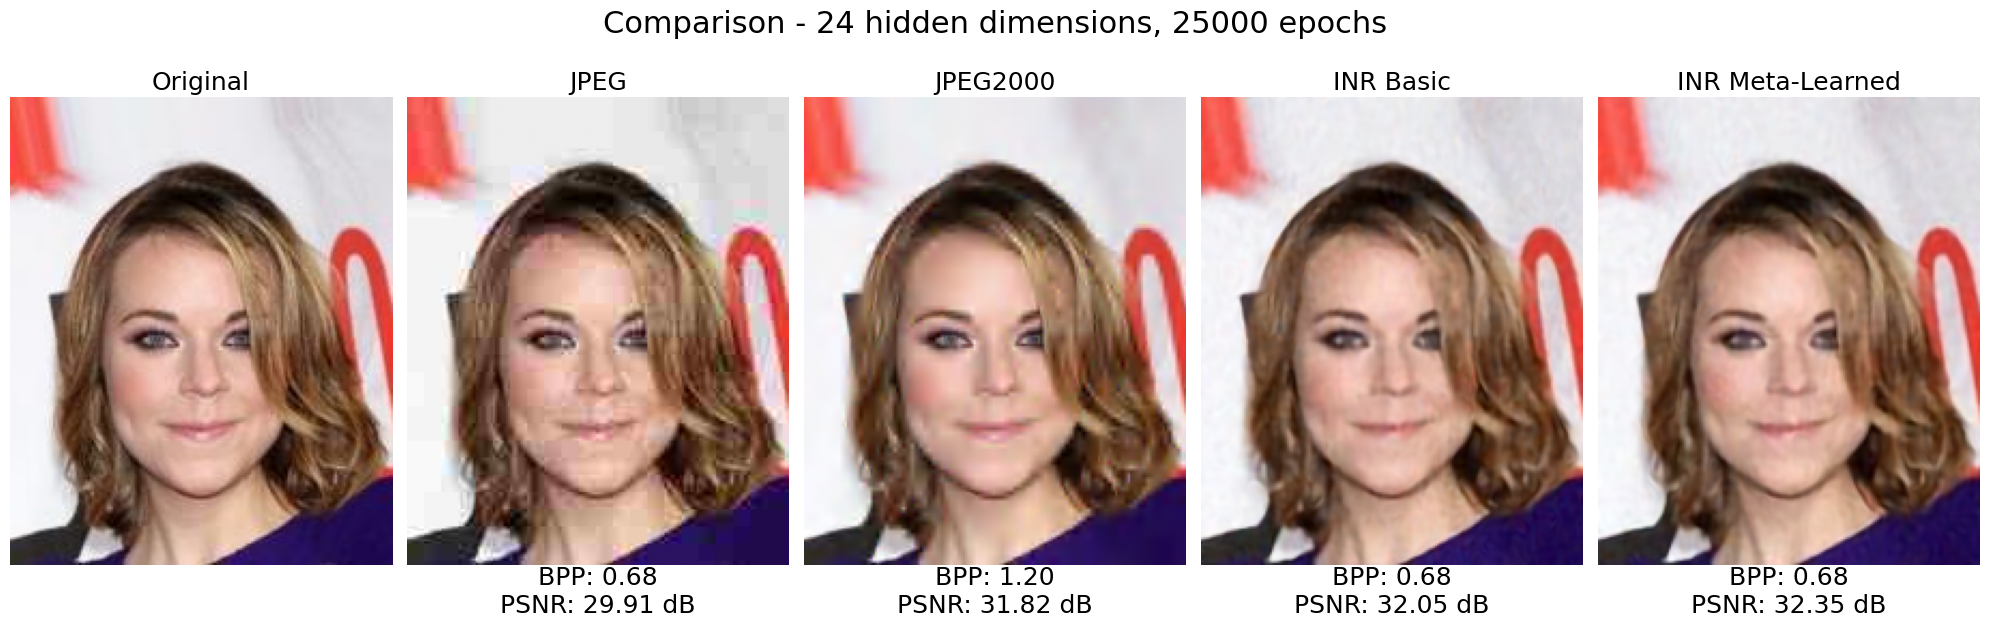

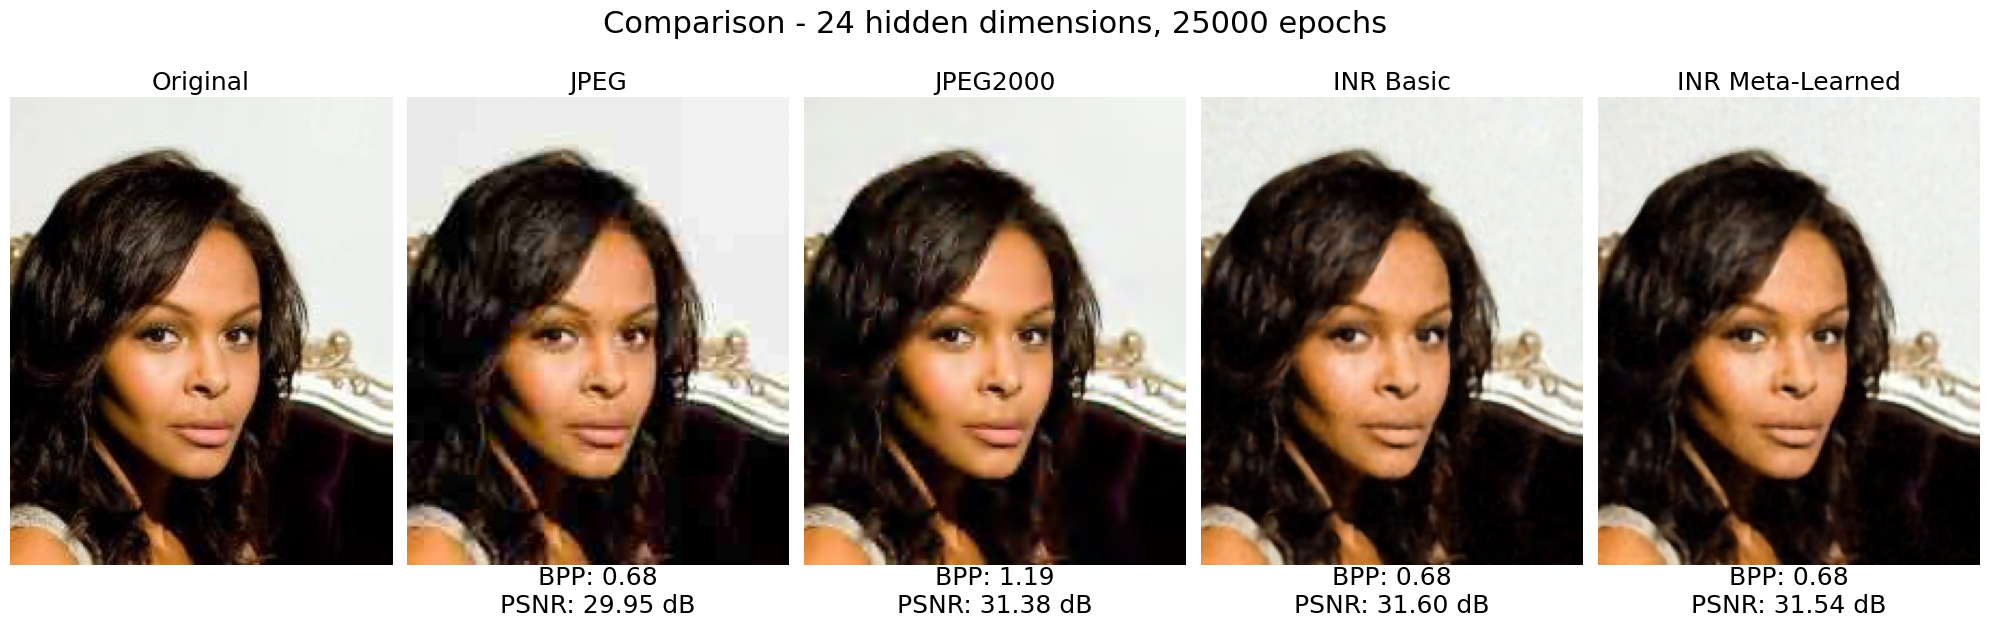

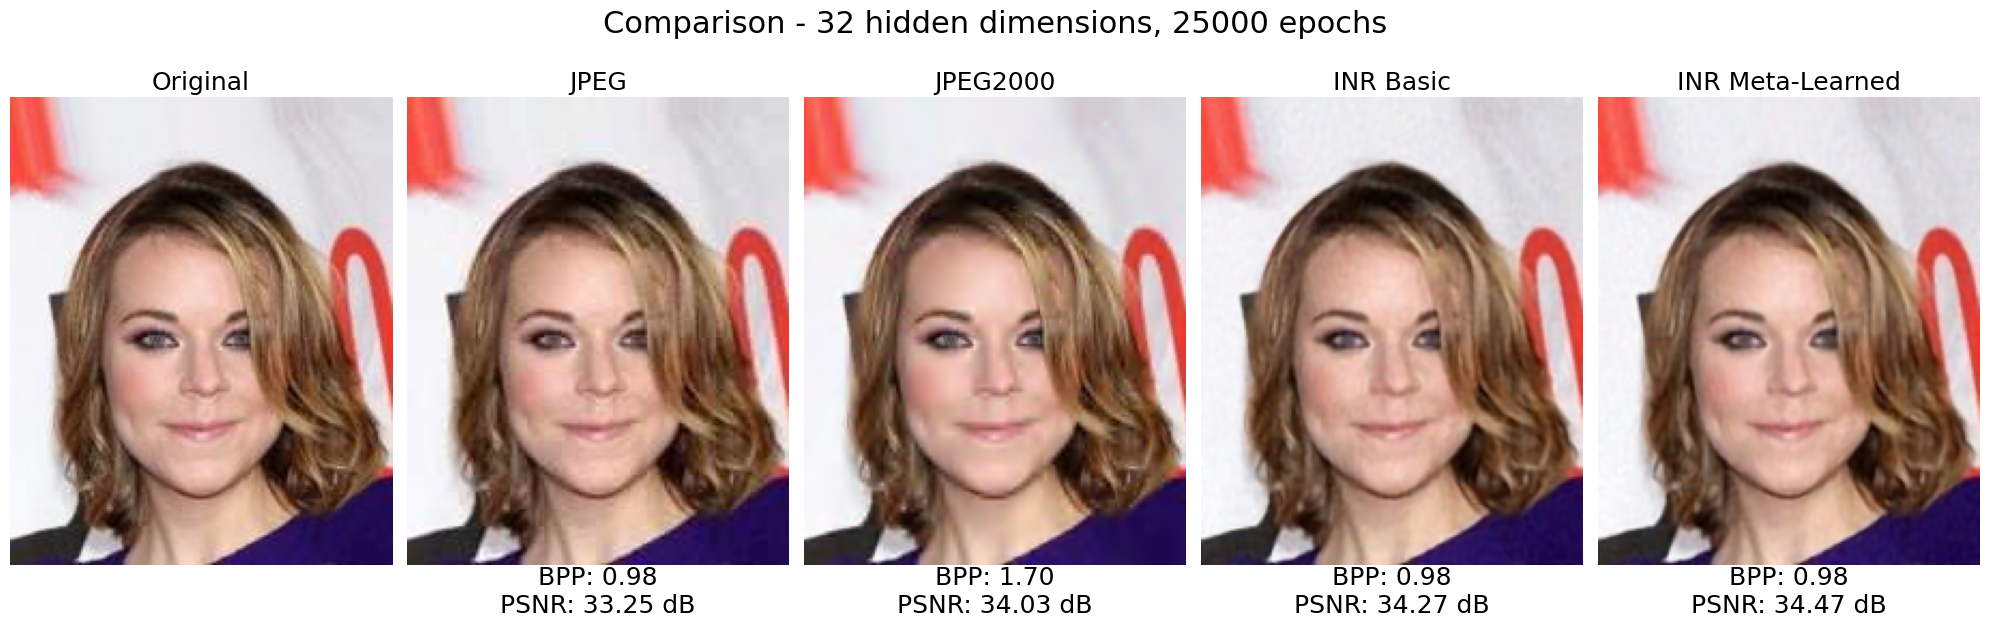

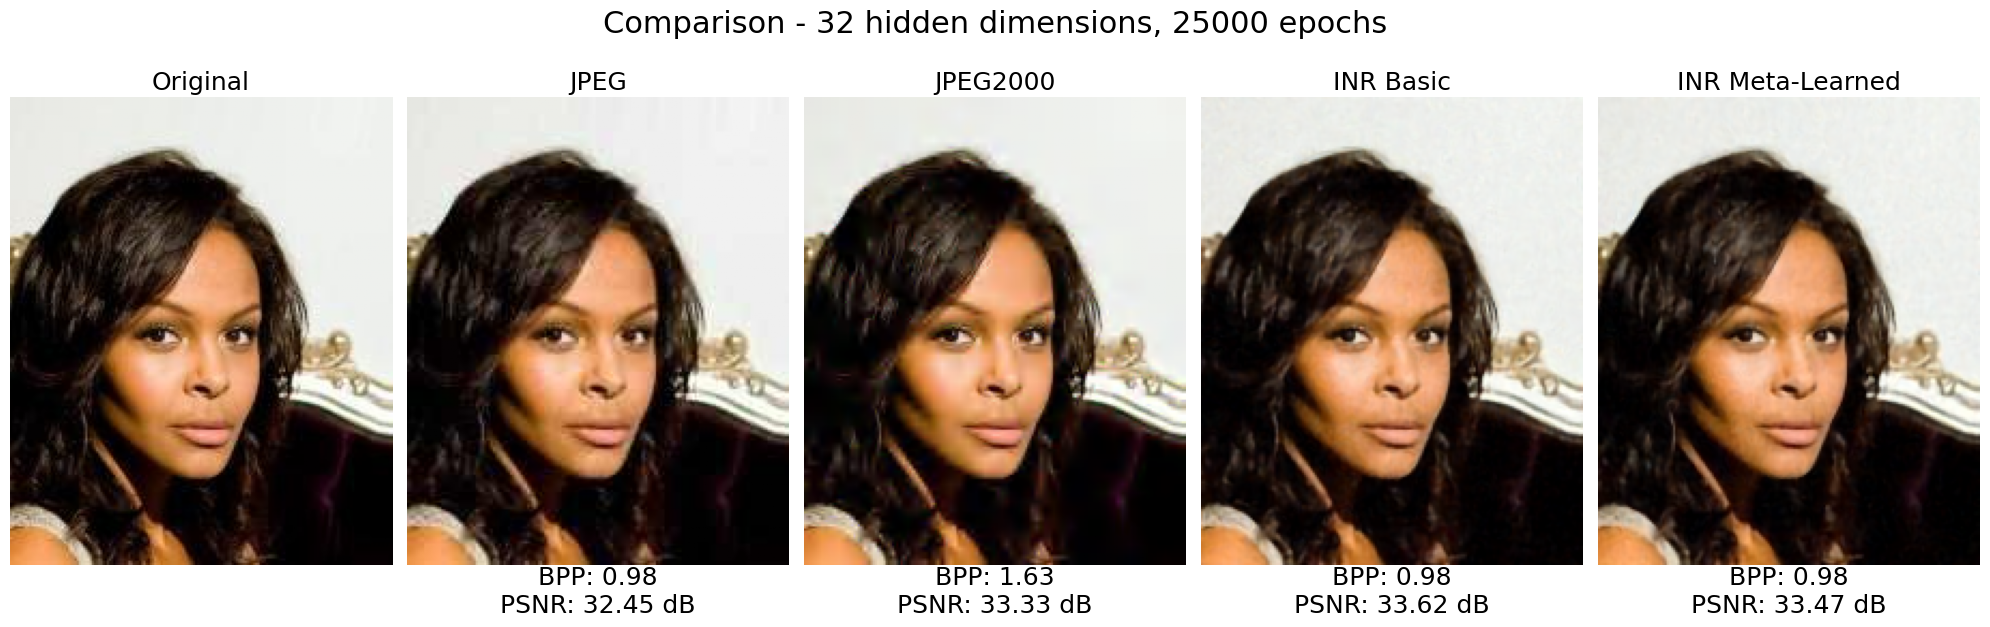

In [11]:
CONFIG.exp_root = "exp/val_basic_celeba"
CONFIG.dataset = "test_celeba"
CONFIG.ffdims = 12

for epoch in [50, 500, 2500, 25000]:
    CONFIG.epochs = epoch
    for hidden_dims in [24, 32, 48, 64]:
        CONFIG.hidden_dims = hidden_dims
        if epoch==25000 and hidden_dims in [24, 32]:
            result_generation(CONFIG, plot=True)
        else:
            result_generation(CONFIG)

DIV2K

/var/folders/v2/ds4hxx8124q9z94wvxnvgmqh0000gn/T/ipykernel_736/1023808166.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

Error for  exp/val_basic_div2k/test_DIV2K_epochs50_hidden_dims96/0887/checkpoints/model_final.pth
Error for  exp/val_basic_div2k/test_DIV2K_epochs50_hidden_dims128/0887/checkpoints/model_final.pth
Error for  exp/val_basic_div2k/test_DIV2K_epochs50_hidden_dims128/0841/checkpoints/model_final.pth
Error for  exp/val_basic_div2k/test_DIV2K_epochs2500_hidden_dims64/0887/checkpoints/model_final.pth
Error for  exp/val_basic_div2k/test_DIV2K_epochs2500_hidden_dims128/0887/checkpoints/model_final.pth


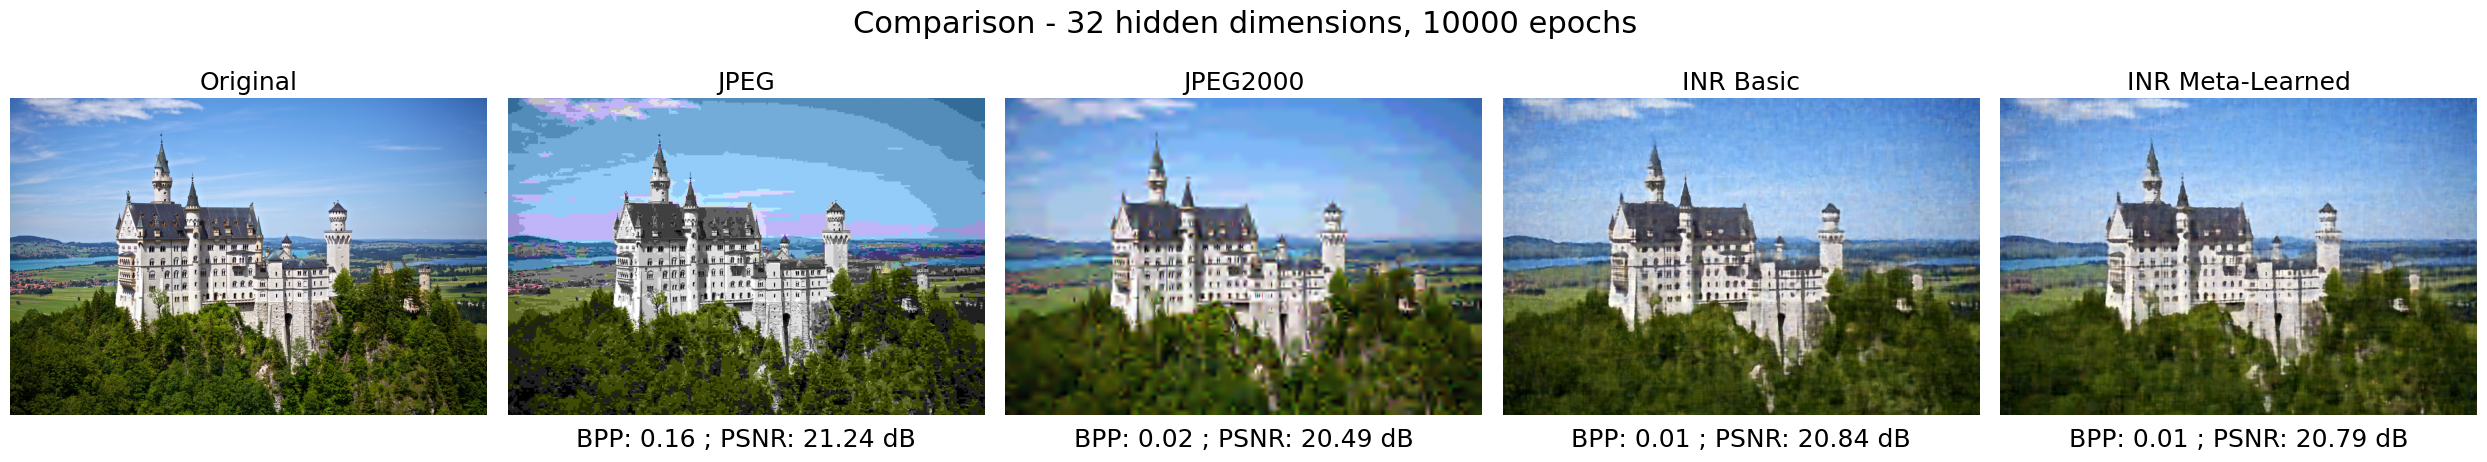

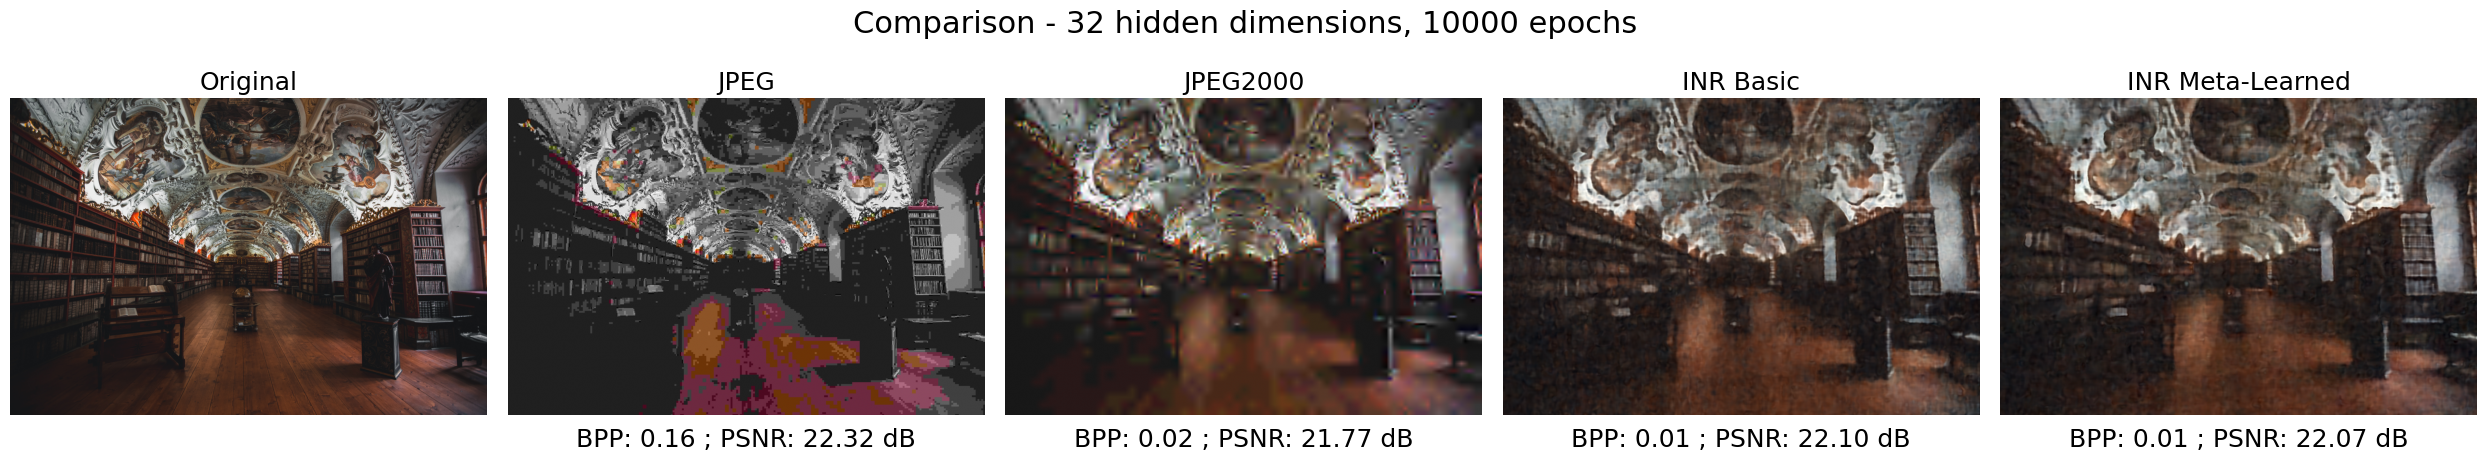

In [8]:
CONFIG.exp_root = "exp/val_basic_div2k"
CONFIG.dataset = "test_DIV2K"
CONFIG.maml_dataset = "DIV2K"
CONFIG.ff_dims = 16

for epoch in [50, 500, 2500]:
    CONFIG.epochs = epoch
    for hidden_dims in [32, 64, 96, 128]:
        CONFIG.hidden_dims = hidden_dims
        result_generation(CONFIG)

# Generation of the results for 10k epochs and 32 hidden dimensions
CONFIG.epochs = 10000
CONFIG.hidden_dims = 32
result_generation(CONFIG, plot=True)

### Quantitative evaluation: PSNR vs BPP curves

In [14]:
def plot_psnr_vs_bpp(original_image_path, CONFIG, output_folder="output/", hidden_dims_list=[24, 32, 48, 64]):
    """Plot PSNR vs BPP for a single image with JPEG, JPEG2000, INR Basic, and INR Meta-Learned."""
    os.makedirs(output_folder, exist_ok=True)

    # Load the original image
    original_image = np.array(Image.open(original_image_path).convert("RGB")) / 255.0
    image_resolution = original_image.shape[:2]

    # Initialize lists to store PSNR and BPP values
    psnr_values = {'JPEG': [], 'JPEG2000': [], 'INR Basic': [], 'INR Meta-Learned': []}
    bpp_values = {'JPEG': [], 'JPEG2000': [], 'INR Basic': [], 'INR Meta-Learned': []}

    # Generate PSNR vs BPP for JPEG by varying quality
    for quality in range(1, 90, 1):  
        jpeg_image_path = os.path.join(output_folder, f"jpeg_quality_{quality}.jpg")
        jpeg_image = compress_jpeg(original_image_path, jpeg_image_path, quality=quality)
        psnr, bpp = compute_metrics_and_bpp(original_image, jpeg_image, jpeg_image_path, image_resolution)
        psnr_values['JPEG'].append(psnr)
        bpp_values['JPEG'].append(bpp)
        os.remove(jpeg_image_path)  # Delete the JPEG file


    # Generate PSNR vs BPP for JPEG2000 by varying quality value in 'dB' mode
    for quality_value in np.linspace(20, 45, 100): 
        jpeg2000_image_path = os.path.join(output_folder, f"jpeg2000_quality_{quality_value}.jp2")
        jpeg2000_image = compress_jpeg2000(original_image_path, jpeg2000_image_path, quality_mode='dB', quality_value=quality_value)
        psnr, bpp = compute_metrics_and_bpp(original_image, jpeg2000_image, jpeg2000_image_path, image_resolution)
        psnr_values['JPEG2000'].append(psnr)
        bpp_values['JPEG2000'].append(bpp)
        os.remove(jpeg2000_image_path)

    for hidden_dims in hidden_dims_list:
        CONFIG.hidden_dims = hidden_dims
        # Get output folders, original paths, and base names
        output_folders, original_paths, base_names = get_output_folders(CONFIG)
        output_folder = output_folders[1]
        # Initialize lists to store PSNR and BPP values
        metrics_path = os.path.join(output_folder, 'compression_metrics.json')
        with open(metrics_path, 'r') as file:
            metrics = json.load(file)

        for method in psnr_values.keys():
            if method != 'JPEG' and method != 'JPEG2000':
                psnr_values[method].append(metrics[method]['PSNR'])
                bpp_values[method].append(metrics[method]['BPP'])
    
    # Plot PSNR vs BPP
    plt.figure(figsize=(10, 6))
    for method in psnr_values.keys():
        if method != 'JPEG' and method != 'JPEG2000':
            plt.plot(bpp_values[method], psnr_values[method], marker='o', label=method)
        else:
            plt.plot(bpp_values[method], psnr_values[method], marker=None, label=method)

    plt.xlabel('Bits Per Pixel (BPP)')
    plt.ylabel('Peak Signal to Noise Ratio (PSNR) [dB]')
    plt.xlim(0, 3)
    plt.ylim(30, 45)
    plt.title(f'PSNR vs BPP for a Single Image of {CONFIG.dataset}')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_metrics_and_bpp(original_image, compressed_image, image_path, image_resolution, inr=False):
    """Compute PSNR and BPP for a given compressed image."""
    psnr_value = psnr(original_image, compressed_image, data_range=1.0)
    bpp_value = calculate_bpp(image_path, image_resolution[0], image_resolution[1], inr=inr)
    return psnr_value, bpp_value

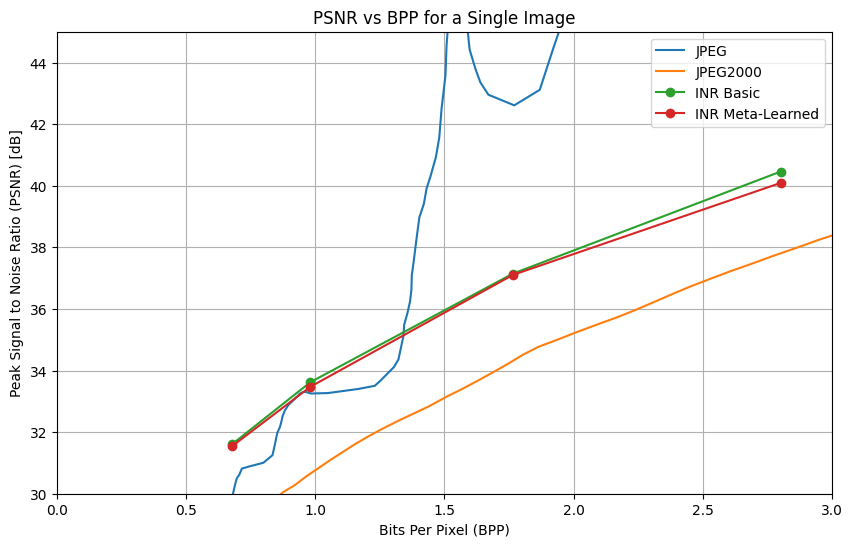

In [15]:
CONFIG.exp_root = "exp/val_basic_celeba"
CONFIG.dataset = "test_celeba"
CONFIG.ffdims = 12
CONFIG.epochs = 25000
original_image_path = "data/test_celeba/183004.jpg"
plot_psnr_vs_bpp(original_image_path, CONFIG)

## Benefits of meta-learning for the convergence speed of the INR compression 

It is also interesting to check the convergence speed of the INR compression methods. This is one of the main benefits of meta-learning: thanks to the meta-learning phase,  

In [27]:
def plot_psnr_vs_bpp_epochs(CONFIG, hidden_dims_list=[24, 32, 48, 64], epochs_list=[50, 500, 2500, 25000]):
    """Plot PSNR vs BPP for a single image with varying epochs for INR Basic and INR Meta-Learned."""
    plt.figure(figsize=(10, 6))
    # Iterate over each epoch setting
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, epoch in enumerate(epochs_list):
        CONFIG.epochs = epoch
        psnr_values = {'INR Basic': [], 'INR Meta-Learned': []}
        bpp_values = {'INR Basic': [], 'INR Meta-Learned': []}
        for hidden_dims in hidden_dims_list:
            CONFIG.hidden_dims = hidden_dims
            # Get output folders, original paths, and base names
            output_folders, original_paths, base_names = get_output_folders(CONFIG)
            output_folder = output_folders[0]
            # Initialize lists to store PSNR and BPP values
            metrics_path = os.path.join(output_folder, 'compression_metrics.json')
            with open(metrics_path, 'r') as file:
                metrics = json.load(file)

            for method in psnr_values.keys():
                psnr_values[method].append(metrics[method]['PSNR'])
                bpp_values[method].append(metrics[method]['BPP'])
        for method in psnr_values.keys():
            if 'Basic' in method:
                plt.plot(bpp_values[method], psnr_values[method], marker='x',linestyle='--', label=f'{epoch} epochs ({method})', color=colors[i])
            else:
                plt.plot(bpp_values[method], psnr_values[method], marker='o', linestyle='-', label=f'{epoch} epochs ({method})', color=colors[i])

    plt.xlabel('Bits Per Pixel (BPP)')
    plt.ylabel('Peak Signal to Noise Ratio (PSNR) [dB]')
    plt.title(f'PSNR vs BPP for Different Epochs - {CONFIG.dataset}')
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.show()


Results for CelebA

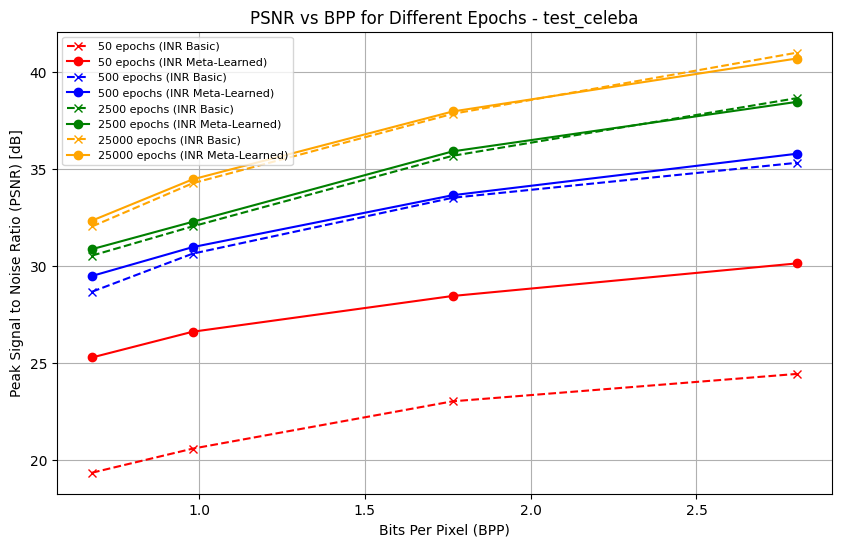

In [28]:
CONFIG.exp_root = "exp/val_basic_celeba"
CONFIG.dataset = "test_celeba"

plot_psnr_vs_bpp_epochs(CONFIG)

Results for DIV2K

In [ ]:
CONFIG.exp_root = "exp/val_basic_div2k"
CONFIG.dataset = "test_DIV2K"

plot_psnr_vs_bpp_epochs(CONFIG, hidden_dims_list=[32, 48, 64, 96, 128], epochs_list=[50, 500, 2500])